In [1]:
import reprlib, os, logging, sys, random
from imageio import imread
from pathlib import Path
import numpy as np
import tensorflow as tf
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage import img_as_uint
import cv2
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from common.filter_banks import make_gauss_kernels, make_dog_kernels
from common.filter_banks import wave_numbers, make_sine_kernels, make_gabor_kernels, conv2d_sq
from common.filter_banks import show_filter_bank, show_filter_response
from common.image_ops import resize_img, whiten_img

log_format = '%(asctime)s | %(levelname)s : %(message)s'
logging.basicConfig(format=log_format, level=logging.INFO, stream=sys.stdout)
logging.info(f"Start with tf version {tf.version.VERSION}")

2020-10-08 16:38:39,769 | INFO : Start with tf version 2.3.1


In [2]:
sz=128

In [3]:
racoon_path = (Path(os.environ['DATA_ALL']) / 'Misc' / 'racoon').with_suffix('.png')
racoon = imread(racoon_path)
racoon = rgb2gray(racoon)
racoon = resize_img(racoon, sz=sz)
racoon = whiten_img(racoon)
racoon = np.reshape(racoon, (1,sz,sz,1))
pixel_min, pixel_max = np.min(racoon), np.max(racoon)
racoon -= pixel_min
racoon /= (pixel_max - pixel_min)
print(np.min(racoon), np.max(racoon))

0.0 1.0


C:\Python36\lib\site-packages\tensorflow\python\framework\constant_op.py:98: ComplexWarning: Casting complex values to real discards the imaginary part
  return ops.EagerTensor(value, ctx.device_name, dtype)


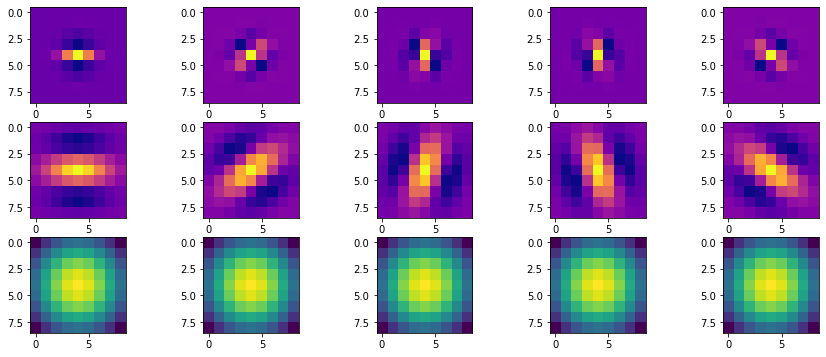

In [4]:
def kernels2tensor(kernels, dtype=tf.float32):
    kernels = np.moveaxis(np.expand_dims(kernels, axis=-1), 0,-1)
    return tf.constant(kernels, dtype=dtype)

def complex_exp(xs, ys, freq, angle_rad):
    return np.exp(freq * (xs*np.sin(angle_rad) + ys*np.cos(angle_rad)) * 1.0j)

def gauss(xs, ys, sigma):
    return (1 / (2 * np.pi * sigma**2)) \
        * np.exp(-(xs*xs + ys*ys) / (2.*sigma*sigma)) 

def make_meshgrid(sz=9):
    return np.meshgrid(np.linspace(-(sz//2), sz//2, sz),
                         np.linspace(-(sz//2), sz//2, sz))

def make_gabor_kernels(xs, ys, directions=3, freqs=[2.0, 1.0]):
    """ """
    angles_rad = [n * np.pi/float(directions) 
                  for n in range(directions)]    
    sine_kernels = kernels2tensor(
        [complex_exp(xs,ys,freq,angle_rad) 
             for freq in freqs
                for angle_rad in angles_rad])    
    sigmas = [2./freq for freq in freqs]
    gauss_kernels = kernels2tensor(
        [gauss(xs,ys,sigma) 
             for sigma in sigmas])
    gauss_kernels = np.repeat(gauss_kernels,
                              sine_kernels.shape[-1] // gauss_kernels.shape[-1], axis=-1)    
    
    bank = gauss_kernels * sine_kernels
    g0 = kernels2tensor([gauss(xs,ys,4./freqs[-1])])
    return tf.concat([bank, g0], -1)

directions = 5
freqs = [2.0, 1.0]
xs,ys = make_meshgrid(sz=9)
gabor_kernels = make_gabor_kernels(xs, ys, directions=directions, freqs=freqs)
fig,axs = plt.subplots(len(freqs)+1, directions, figsize=(directions*3,len(freqs)*3))
for n in range(directions):
    for m in range(len(freqs)):
        img = tf.squeeze(gabor_kernels[...,0, m*directions+n])
        axs[m][n].imshow(tf.math.real(img), cmap='plasma')
g0 = tf.squeeze(gabor_kernels[...,0,-1])
for n in range(directions):
    axs[len(freqs)][n].imshow(tf.squeeze(g0))

In [5]:
def v1_v2(in_image, reshape_result = False):
    v1_response = \
        tf.nn.conv2d(in_image, 
                     tf.math.real(gabor_kernels), strides=1, padding='SAME') ** 2 \
            + tf.nn.conv2d(in_image, 
                           tf.math.imag(gabor_kernels), strides=1, padding='SAME') ** 2

    v1_response_sub = \
        tf.nn.max_pool(v1_response, (2,2), 
                       strides=2, padding='SAME')
    v1_response_sub = tf.squeeze(v1_response_sub)
    # tf.print(f"tf.squeeze(v1_response_sub): {v1_response_sub.shape}")
    v1_response_sub = tf.transpose(v1_response_sub, perm=[2,0,1])
    # tf.print(f"tf.transpose(v1_response_sub, perm=[2,0,1]) = {v1_response_sub.shape}")
    v1_response_sub = v1_response_sub[...,tf.newaxis]
    # tf.print(f"v1_response_sub[...,tf.newaxis]: {v1_response_sub.shape}")
    
    v2_response = \
        tf.nn.conv2d(v1_response_sub, 
                     tf.math.real(gabor_kernels), strides=1, padding='SAME') ** 2 \
            + tf.nn.conv2d(v1_response_sub, 
                           tf.math.imag(gabor_kernels), strides=1, padding='SAME') ** 2
    
    if reshape_result:
        v2_response = \
            tf.reshape(v2_response, 
                       [-1, v2_response.shape[1], 
                            v2_response.shape[2] * v2_response.shape[3]])
    
    v2_response_sub = \
        tf.nn.max_pool(v2_response, (2,2), 
                       strides=2, padding='SAME')
    # print(v2_response_sub.shape)
    
    return v2_response_sub

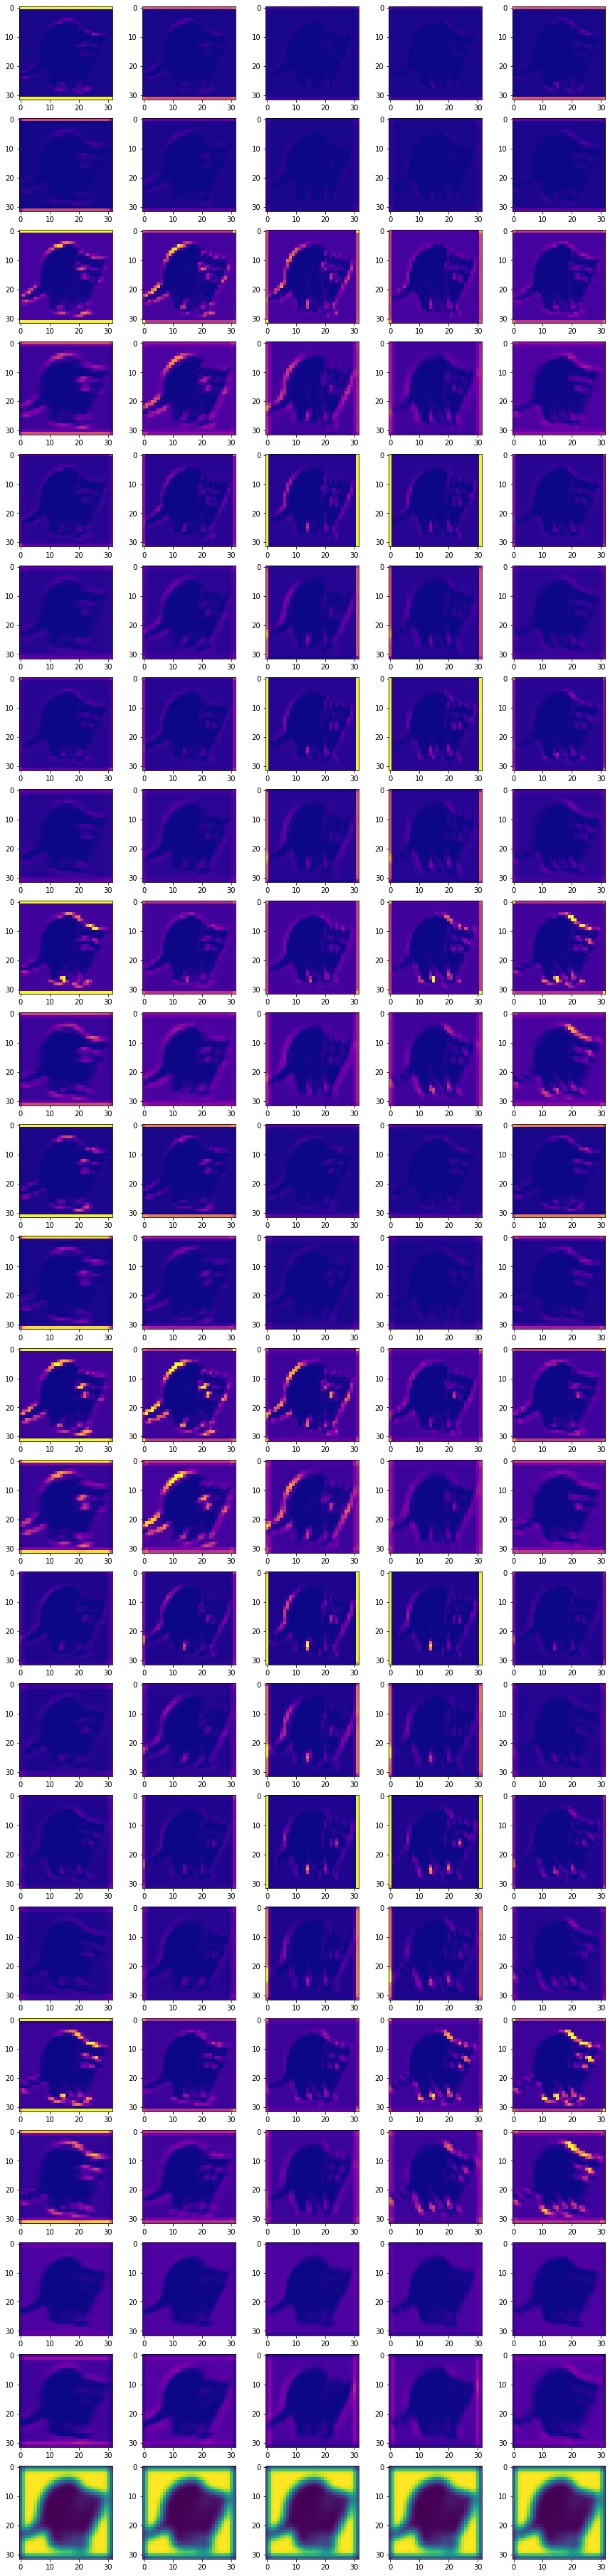

In [6]:
racoon_v2_response_sub = v1_v2(racoon)

fig,axs = plt.subplots(racoon_v2_response_sub.shape[0]*len(freqs)+1, 
                       directions, figsize=(directions*3,
                                            racoon_v2_response_sub.shape[0]*len(freqs)*3))

noisy = False
if noisy:
    noise = np.random.rand(racoon_v2_response_sub.shape[0],
                               racoon_v2_response_sub.shape[1],
                               racoon_v2_response_sub.shape[2],
                               racoon_v2_response_sub.shape[3])
    for l in range(racoon_v2_response_sub.shape[0]):
        vmax = tf.reduce_max(racoon_v2_response_sub[l,...])
        # print(vmax.numpy())
        noise[l,...] *= (vmax/1000.)
        # print(noise.shape)
        
    # racoon_v2_response_sub = racoon_v2_response_sub + noise
    racoon_v2_response_sub = \
        tf.clip_by_value(racoon_v2_response_sub, clip_value_min=5e-6, clip_value_max=1.)
    pixel_min = tf.reduce_min(racoon_v2_response_sub)
    print(f"{tf.size(tf.where(racoon_v2_response_sub[racoon_v2_response_sub == pixel_min]))} of {tf.size(racoon_v2_response_sub)}")

for l in range(racoon_v2_response_sub.shape[0]):
    vmax = tf.reduce_max(racoon_v2_response_sub[l,...])
    
    for m in range(len(freqs)):
        for n in range(directions):
            img = tf.squeeze(racoon_v2_response_sub[l,...,m*directions+n])
            axs[m+(l*2)][n].imshow(tf.math.real(img), cmap='plasma', vmin=0., vmax=vmax/2.)
    g0 = tf.squeeze(racoon_v2_response_sub[l,...,-1])
    for n in range(directions):
        axs[len(freqs)+(l*2)][n].imshow(g0)

In [7]:
current_value = tf.Variable(0.5 * np.ones((1,sz,sz,1)), dtype=tf.float32)

vmax = tf.math.reciprocal(tf.reduce_max(racoon_v2_response_sub, axis=[1,2]))

def flatten_last(tensor, dims=4):
    return tf.reshape(tensor, (tensor.shape[0], tensor.shape[1], tensor.shape[2] * tensor.shape[3]))
    
def cross_entropy_loss(current, match):
    global vmax
    current_flattened = flatten_last(tf.transpose(current, perm=[3,0,1,2]))
    match_flattened = flatten_last(tf.transpose(match, perm=[3,0,1,2]))
    cross_entropy = tf.keras.losses.binary_crossentropy(match_flattened, current_flattened)
    loss = tf.tensordot(cross_entropy, vmax, axes=2)
    return loss

def cosine_loss(current, match):
    dot_prod = tf.tensordot(current, match, axes=4)
    loss = dot_prod / (tf.norm(current, ord='euclidean') * tf.norm(match, ord='euclidean'))
    return loss

def mse_loss(current, match):
    loss_per_bank = tf.reduce_mean((current - match) ** 2, axis=[1,2])
    loss = tf.tensordot(loss_per_bank, vmax, axes=2)
    return loss

loss_function = cross_entropy_loss
with tf.GradientTape() as tape:
    current_v2_response_sub = v1_v2(current_value)
    loss = loss_function(current_v2_response_sub, racoon_v2_response_sub)

grad = tape.gradient(loss, current_value)
logging.info(f"Loss = {loss}, Gradient max = {np.max(grad)}")
optimizer = tf.optimizers.Adam(1e-3)
optimizer.apply_gradients(zip([grad], [current_value]))

2020-10-08 16:39:26,321 | INFO : Loss = 896.4483642578125, Gradient max = 0.029389113187789917


<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

2020-10-08 16:39:29,822 | INFO : Animation.save using <class 'matplotlib.animation.HTMLWriter'>


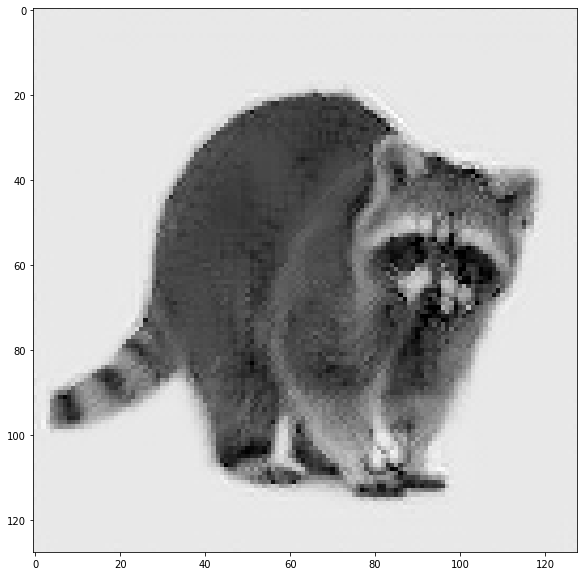

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
im_axis = ax.imshow(np.squeeze(current_value.numpy()), cmap='gray', vmin=0., vmax=1.1)

def iterate(i):
    global grad, current_value
    for n in range(100):
        optimizer.apply_gradients(zip([grad], [current_value]))
        with tf.GradientTape() as tape:
            current_v2_response_sub = v1_v2(current_value)
            loss = loss_function(current_v2_response_sub, racoon_v2_response_sub)
        grad = tape.gradient(loss, current_value)
        
    # logging.info(loss)
    im_axis.set_data(np.squeeze(current_value.numpy()))

ani = animation.FuncAnimation(fig, iterate, frames=50)
HTML(ani.to_jshtml())